In [1]:
import os, sys, json
from pyomo.environ import *
from pyomo.dae import *
from pyomo.dae.simulator import Simulator
import numpy as np
import logging
logging.getLogger('pyomo.core').setLevel(logging.ERROR)
import matplotlib.pyplot as plt
exp_data = {
    'time':[0,1,2,3,4,5,6,7,8,9,10,24],
    'acetoin':[971.0439913,682.6181848,459.208027,308.3003315,263.2544518,149.8680396,
               93.46151024,47.84479588,16.04114794,3.147777154,0.5864201,0],
    '23bd':[0,253.390451,499.7211577,640.7983832,692.9552927,806.5389984,843.7616898,
                915.953227,938.4841003,953.1739333,959.6760942,975.8266099],
    'hco2':[106.4470588,17.11434343,20.22083859,33.91695502,35.67344451,52.71546131,
                59.38795452,69.70842223,64.98969826,73.3982515,169.3867239,188.6024144]
}
fdh_ids = [132, 18, 192, 25, 291, 32, 61,38]
bdh_ids = [212, 302, 478, 101]

In [2]:
def create_model(maxtime,form_add_rate,bdh_id,fdh_id):

    with open(f'./BDH solutions/BDH_optimal_results_data_{bdh_id}.txt') as f:
        bdh_res = json.load(f)
    with open(f'./FDH solutions/FDH_optimal_results_data_{fdh_id}.txt') as f:
        fdh_res = json.load(f)
    model = ConcreteModel()
    #BDH variables
    del bdh_res['kp']['kcat_f']['NADH_decomp']
    del bdh_res['kp']['kcat_r']['NADH_decomp']
    model.KM_products = Param(Set(initialize=['BDH+23bd','BDH+nad']),initialize=bdh_res['kp']['Km_p'])
    model.KM_reactants = Param(Set(initialize=['BDH+acetoin','BDH+nadh','NADH_decomp+nadh']),initialize=bdh_res['kp']['Km_r'])
    model.Kcat_f = Param(Set(initialize=['BDH']),initialize=bdh_res['kp']['kcat_f'])
    model.Kcat_r = Param(Set(initialize=['BDH']),initialize=bdh_res['kp']['kcat_r'])
    #FDH initialization
    model.kcat = Param(initialize=fdh_res['kp']['kcat']['FDH+f'])
    model.Km = Param(Set(initialize = ["FDH+hco2","FDH+nad"]), initialize=fdh_res['kp']['Km'])
    model.Kconsts = Param(initialize=fdh_res['kp']['Kconsts']['NADH_decomp+nadh'])
    model.Ki = Param(Set(initialize=['FDH+nad','FDH+nadh']),initialize=fdh_res['kp']['Ki'])
    #define components
    model.TIME = ContinuousSet(bounds=(0,maxtime))
    model.c = Var(model.TIME, Set(initialize = ['acetoin', 'nadh', 'nad', '23bd', 'hco2', 'co2']))
    model.fdh_rate = Var(model.TIME)
    model.bdh_rate = Var(model.TIME)
    model.nadh_decomp = Var(model.TIME)
    model.dcdt = DerivativeVar(model.c, wrt=model.TIME, within=Reals)
    model.e = Var(model.TIME, Set(initialize=['BDH','FDH']))
    #dcdt
    def dcdt_acetoin(m,t):
        return m.dcdt[t,'acetoin'] == - m.bdh_rate[t]
    model.diff_acetoin = Constraint(model.TIME,rule=dcdt_acetoin)
    def dcdt_nadh(m,t):
        return m.dcdt[t,'nadh'] == -m.bdh_rate[t]  - m.nadh_decomp[t] + m.fdh_rate[t]
    model.diff_nadh = Constraint(model.TIME,rule=dcdt_nadh)
    def dcdt_nad(m,t):
        return m.dcdt[t,'nad'] == m.bdh_rate[t] - m.fdh_rate[t]
    model.diff_nad = Constraint(model.TIME,rule=dcdt_nad)
    def dcdt_23bd(m,t):
        return m.dcdt[t,'23bd'] == m.bdh_rate[t]
    model.diff_23bd = Constraint(model.TIME,rule=dcdt_23bd)
    def dcdt_hco2(m,t):
        return m.dcdt[t,'hco2'] ==  -m.fdh_rate[t] + form_add_rate
    model.diff_hco2 = Constraint(model.TIME,rule=dcdt_hco2)
    def dcdt_co2(m,t):
        return m.dcdt[t,'co2'] == m.fdh_rate[t]
    model.diff_co2 = Constraint(model.TIME,rule=dcdt_co2)
    #define rates
    def bdh_rate(m,t):
        num = (m.Kcat_f['BDH']*(m.c[t,'acetoin']*m.c[t,'nadh'])/(m.KM_reactants['BDH+acetoin']*m.KM_reactants['BDH+nadh'])- 
               m.Kcat_r['BDH']*(m.c[t,'23bd']*m.c[t,'nad'])/(m.KM_products['BDH+23bd']*m.KM_products['BDH+nad']))
        den = (1+m.c[t,'acetoin']/m.KM_reactants['BDH+acetoin'])*(1+ m.c[t,'nadh']/m.KM_reactants['BDH+nadh']) + \
               (1+ m.c[t,'23bd']/m.KM_products['BDH+23bd'])*(1+ m.c[t,'nad']/m.KM_products['BDH+nad'])
        return m.bdh_rate[t] == num/den * m.e[t,'BDH']        
    model.bdh_rxn_rate = Constraint(model.TIME, rule=bdh_rate)
    def fdh_rate(m,t):
        num = m.kcat * m.c[t,'nad'] * m.c[t,'hco2'] * m.e[t,'FDH']
        den = m.Ki['FDH+nad'] * m.Km['FDH+hco2'] + \
              m.Km['FDH+hco2'] * m.c[t,'nad'] + \
              m.Km['FDH+nad'] * m.c[t,'hco2'] + \
              m.c[t,'nad'] * m.c[t,'hco2'] + \
              (m.Ki['FDH+nad']*m.Km['FDH+hco2'])/(m.Ki['FDH+nadh'])*m.c[t,'nadh'] + \
              (m.Km['FDH+nad']/m.Ki['FDH+nadh']) * m.c[t,'hco2'] * m.c[t,'nadh']
        return m.fdh_rate[t] == num/den 
    model.fdh_rxn_rate = Constraint(model.TIME, rule=fdh_rate)
    def nadh_decomp(m,t):
        return m.nadh_decomp[t] == m.Kconsts* m.c[t,'nadh']
    model.nadh_decomp_rate = Constraint(model.TIME, rule=nadh_decomp)
    def FDH_conc(m,t):
        #return m.e[t,'FDH'] == 0.0198 / (1.0899e-6)
        return m.e[t,'FDH'] == 0.0198 / (2.51e-3)
    model.fdh_add = Constraint(model.TIME, rule=FDH_conc)
    def BDH_conc(m,t):
        return m.e[t,'BDH'] == 0.0069 / (1.4131e-7)
    model.bdh_add = Constraint(model.TIME, rule=BDH_conc)

    return model

In [3]:
def simulate_model(m,datapoints):
    int_ops = {'print_stats':False,"abstol":1E-8,"reltol":1E-6}
    # Simulate the model using casadi
    sim = Simulator(m, package='casadi')
    tsim, profiles = sim.simulate(numpoints=datapoints+1, integrator='idas',integrator_options=int_ops)

    # Discretize model using Orthogonal Collocation
    discretizer = TransformationFactory('dae.finite_difference')
    discretizer.apply_to(model,wrt=model.TIME,nfe=datapoints+1,scheme='BACKWARD')

    # Initialize the discretized model using the simulator profiles
    sim.initialize_model()

    return sim, tsim, profiles

def plot_result(m, sim, tsim, profiles):
    import matplotlib.pyplot as plt

    time = list(m.TIME)

    varorder = sim.get_variable_order()
    algorder = sim.get_variable_order(vartype='algebraic')

    for idx1, v in enumerate(varorder):
        plt.plot(tsim, profiles[:, idx1], label=v)

    plt.xlabel('t')
    plt.legend(loc='best')
    plt.show()

In [6]:
%%capture
form_add_rates = {
    60:4.628301761,
    120:3.047268338,
    180:1.373303847,
    240:2.26983505,
    300:1.377732211,
    360:0.218306048,
    420:2.746208048,
    480:0.920658599,
    540:0.301448878,
    600:0.398002298,
    1440:0.02266383
}

all_concentrations = {}
counter = 0 

for_total = [103.786]

for bdh_id in bdh_ids:
    for fdh_id in fdh_ids:
        time = [];lasttime = 0
        concentrations = {'acetoin':[],'nadh':[],'nad':[],'23bd':[],'hco2':[],'co2':[]}
        done = True
        for t in list(form_add_rates):

            #initial conditions
            if t == 60:
                model = create_model(60,form_add_rates[60],bdh_id,fdh_id)
                model.c[0,'acetoin'] = 971.04399
                model.c[0,'nadh'] = 1
                model.c[0,'nad'] = 0
                model.c[0,'23bd'] = 0
                model.c[0,'hco2'] = 103.786
                model.c[0,'co2'] = 0

            else:   

                model = create_model(t-lasttime,form_add_rates[t],bdh_id,fdh_id)
                #initial conditions carryover
                model.c[0,'acetoin'] = profiles[:,0][-1]
                model.c[0,'nadh'] = profiles[:,1][-1]
                model.c[0,'nad'] = profiles[:,2][-1]
                model.c[0,'23bd'] = profiles[:,3][-1]
                model.c[0,'hco2'] = profiles[:,4][-1]
                model.c[0,'co2'] = profiles[:,5][-1]
            try:
                sim, tsim, profiles = simulate_model(model,t-lasttime)
                
                time += [t + lasttime for t in list(tsim)[:-1]]    
                lasttime = 60 if t == 60 else t
                concentrations['acetoin'] = concentrations['acetoin'] + list(profiles[:,0])[:-1]
                concentrations['nadh'] = concentrations['nadh'] + list(profiles[:,1])[:-1]
                concentrations['nad'] = concentrations['nad'] + list(profiles[:,2])[:-1]
                concentrations['23bd'] = concentrations['23bd'] + list(profiles[:,3])[:-1]
                concentrations['hco2'] = concentrations['hco2'] + list(profiles[:,4])[:-1]
                concentrations['co2'] = concentrations['co2'] + list(profiles[:,5])[:-1]
                for_total.append(for_total[-1] + list(profiles[:,4])[-1])
            except RuntimeError:
                done = False
                break
        if done:
            #store concentration simulations
            all_concentrations.update({counter:concentrations})
            counter += 1
            
#average out with error on all concentration simulations            
mean_conc = {'acetoin':[],'nadh':[],'nad':[],'23bd':[],'hco2':[],'co2':[]}
std_conc = {'acetoin':[],'nadh':[],'nad':[],'23bd':[],'hco2':[],'co2':[]}
time = list(np.linspace(0,1439,1440))
for met in mean_conc:
    dyn_conc = [];dyn_std = []
    for t,tt in enumerate(time):
        tmp_conc = []
        for i in all_concentrations:
            tmp_conc.append(all_concentrations[i][met][t])
        #bound filtering
        mc = np.mean(tmp_conc); ms = np.std(tmp_conc)
        #if mc + ms >= 1000: ms = 1000 - mc
        #if mc - ms <= 0: ms = mc
        if ms < 0 : ms = 0
        dyn_conc.append(mc)
        dyn_std.append(ms)
    mean_conc[met] = dyn_conc
    std_conc[met] = dyn_std

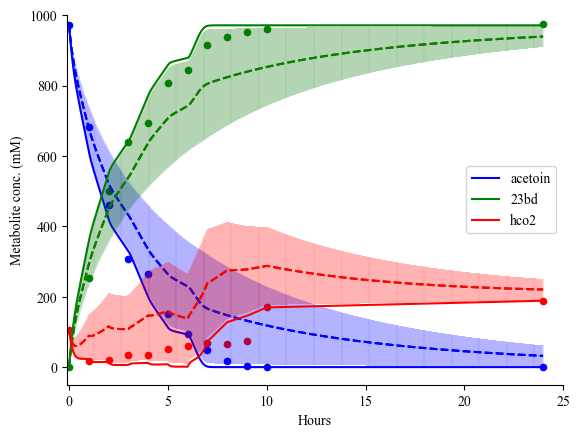

In [7]:
import matplotlib.pyplot as plt
colors = {'acetoin':'blue',
          'hco2':'red',
          '23bd':'green',
          'nadh':'orange',
          'nad':'purple',
          'co2':'yellow'
}
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["Times New Roman"]
for i,met in enumerate(concentrations):
    if met in ['acetoin','hco2','23bd']:
        plt.plot([t/60 for t in time], mean_conc[met], color=colors[met],linestyle='--')
        plt.plot([t/60 for t in time], concentrations[met], label=met, color=colors[met],linestyle='-')
        plt.plot([t/60 for t in time], mean_conc[met],  color=colors[met],linestyle='--')
        plt.errorbar([t/60 for t in time], mean_conc[met],yerr=std_conc[met],ecolor=colors[met],alpha=0.05)
plt.scatter(exp_data['time'],exp_data['acetoin'],color=colors['acetoin'],s=20)
plt.scatter(exp_data['time'],exp_data['23bd'],color=colors['23bd'],s=20)
plt.scatter(exp_data['time'],exp_data['hco2'],color=colors['hco2'],s=20)
#plt.plot(exp_data['time'],for_total,color='orange',linestyle='--')
plt.xlabel('Hours')
plt.ylabel('Metabolite conc. (mM)')
plt.xlim(-0.1,25)
plt.ylim(-50,1000)
plt.legend(loc='best')
ax = plt.gca()
ax.spines[['right', 'top']].set_visible(False)

plt.show()